# Visual Analytics : Assignment 3 
>#### <font color="#2196F3">Meghna Ramachandra Holla (B00812604) </font>
***

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble.bagging import BaggingClassifier
from sklearn import svm
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors.classification import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
import csv

##### Data Load 

In [34]:
# Loading data from CSV file
def load_data(fileName):
    path_to_file = fileName
    data_set = pd.read_csv(path_to_file)
    return data_set

##### Splitting categorical and numerical columns. Removed Target column from Categorical column

In [35]:
#Method to split numerical and categorical data
def splitData(dataset):
    #gathering numerical values only
    datatype_numeric = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numericalValues = dataset.select_dtypes(include=datatype_numeric)
    categoricalValues = dataset.select_dtypes(exclude=datatype_numeric)   
    categoricalValues = categoricalValues.loc[:, categoricalValues.columns != 'salary']
    
    return (numericalValues, categoricalValues)

In [36]:
#Global Variables
accuracyArr = []
f1ScoreArr = []
labelsArr = []
variationF1Score = []
feature_old= []
feature_new = []

##### Converted categorical data into binary columns. Normalized numerical columns. Merged all columns

In [37]:
#Method to normalize the data
def normalizeDataFrame(numericalValues, categoricalValues, data_set, opt=0):
    
    categorical_df =  pd.get_dummies(categoricalValues, columns=list(categoricalValues.columns))
    
    arr = numericalValues.values.astype('float64') 
    min_max_scaler = preprocessing.MinMaxScaler()
    arr_scaled = min_max_scaler.fit_transform(arr)
    numerical_df = pd.DataFrame(arr_scaled)
    
    merged_df=pd.concat([numerical_df,categorical_df],axis=1)
    
    return (categorical_df.columns,merged_df)


##### Calculating F1 Score and Accuracy

In [38]:
#MEthod to calculate Accuracy and F1 Score with Macro average
def accuracy_f1Score(model, y_pred, y_test,flag=0):
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1Score = metrics.f1_score(y_test, y_pred, average='macro')
    
    if(flag==0):
        print("Accuracy Score for",model,"model is", round((accuracy*100),2))
        print("F1 Score for",model,"model is", round((f1Score*100),2))  
        accuracyArr.append((accuracy*100))
        f1ScoreArr.append((f1Score*100))
        labelsArr.append(model)
        print("\n")
    else:
        variationF1Score.append(round((f1Score*100),2))
    

##### SVM Classifier

In [39]:
def svmClassifier(X_train, X_test, y_train, y_test):
    classifier = svm.SVC(gamma='scale')
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy_f1Score("SVM", y_pred, y_test)

##### Random Forest Classifier

In [40]:
def randomForestClassifier(X_train, X_test, y_train, y_test,n_estimators=15, flag=0):
    classifier = RandomForestClassifier(n_estimators=n_estimators)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy_f1Score("Random Forest", y_pred, y_test,flag)    

##### K-Nearest Neighbors Classifier

In [41]:
def knnClassifier(X_train, X_test, y_train, y_test):
    classifier = KNeighborsClassifier(n_neighbors=8)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test) 
    accuracy_f1Score("KNN", y_pred, y_test)        

##### Bar Graph to compare Accuracy and F1 Score of all three models

In [42]:
#Method to create bar graph
def classifierComparisonGraph():
    size = np.arange(len(labelsArr))  
    width = 0.15  
    
    fig, x = plt.subplots(figsize=[10,5])
    
    rects1 = x.bar(size - width/2, f1ScoreArr, width, label='F1 Score',color='#ed5565')
    rects2 = x.bar(size + width/2, accuracyArr, width, label='Accuracy',color='#f8ac59')
    x.set_ylabel('Scores')
    x.set_title('F1 score and Accuracy Score')
    x.set_xticks(size)
    x.set_xticklabels(labelsArr)
    x.legend(loc='lower right')
    


##### Calculating F1 score for different n_estimator values

In [43]:
#Method to create line chart with F1 score variation
def f1ScoreVariation(X_train, X_test, y_train, y_test):
    index=[]
    for i in range(1,11):
        index.append(i*100)
        randomForestClassifier(X_train, X_test, y_train, y_test, i*100, 1)
    
    df = pd.DataFrame({'f1_score_macro':variationF1Score}, index=index)
    df.plot.line()

##### Performed GridSearchCV to get best parameters. Created a model with these parameters

In [44]:
#Method to run GridSearchCV and build RF model with optimized parameters
def gridSearchRandomForest(X_train, X_test, y_train, y_test):
    #Possible combination of parameters - hyper parameters
    param_grid= {
        'min_samples_leaf': [2, 4],
        'min_samples_split': [5, 10],
        'n_estimators': [100, 200, 400, 500]
    }
    
    rf_classifier = RandomForestClassifier(random_state=20) #verbose=1
    grid_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv= 4, scoring='f1_macro')
    grid_result = grid_rf.fit(X_train, y_train)
    print("Accuracy Score based on optimized parameters:",grid_result.best_score_)
    print("The best parameters",grid_result.best_params_)
    
    #using the hyper parameters
    classifier = RandomForestClassifier(min_samples_leaf=2, min_samples_split= 10, n_estimators=400)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy_f1Score("Random Forest", y_pred, y_test)  
    
    return classifier




##### Predicting test data

In [45]:
#Using optimized model to predict with test data
def predictTestData(classifier, feature_old):
    
    data_set = load_data("dataset1_test.csv")
    
    data_set = data_set.loc[:, data_set.columns != 'capital-gain'] #removing this column to match the training data
    numericalValues, categoricalValues = splitData(data_set)
    
    feature_new, X_test = normalizeDataFrame(numericalValues, categoricalValues, data_set,1)
    diff_a = list(set(feature_old)-set(feature_new))
    X_test[diff_a[0]] = 0 #adding zero to the missing column in test data
    
    y_pred = classifier.predict(X_test)
    return y_pred
    
    

##### Storing predicted values in CSV file

In [46]:
#Stored the prediction in csv file
def writeToCsv(values):
    writer = csv.writer(open ('B00812604_prediction.csv', 'w'), delimiter=',', lineterminator='\n')
    for pred in values : writer.writerow ([pred])

In [47]:
def main():
    
    data_set = load_data("dataset1_processed.csv") 

    numericalValues, categoricalValues = splitData(data_set)
    
    labelEncode = preprocessing.LabelEncoder()
    
    feature_old, feature = normalizeDataFrame(numericalValues, categoricalValues, data_set)
    target = labelEncode.fit_transform(data_set['salary'])
    X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=120)
    
    svmClassifier(X_train, X_test, y_train, y_test)
    randomForestClassifier(X_train, X_test, y_train, y_test)
    knnClassifier(X_train, X_test, y_train, y_test)

    classifierComparisonGraph()
    f1ScoreVariation(X_train, X_test, y_train, y_test)
    bestModel = gridSearchRandomForest(X_train, X_test, y_train, y_test)
    
    y_pred = predictTestData(bestModel, feature_old)
    y_pred = list(labelEncode.inverse_transform(y_pred))
    writeToCsv(y_pred)


#### Answers
- A1:The Categorical values that were binarized using One-Hot encoding techniques are workclass, fnlwgt, education, marital-status, occupation, relationship, race, sex and native-country. The Numerical Values that were scaled from 0 to 1 and normalized are capital-loss, hours-per-week, education-num and age.
- A3: The three machine learning classification algorithms used are Support Vector Machine (SVM), Random Forest and K-Nearest Neighbors (KNN).  
    - Random forest performs better with large amount of training data. Also, they work well with categorical data. Therefore, from the results, it is seen that Random Forest classifier has the highest F1 score. Random forest classifier has given an F1 score of <b> 74.59 </b>
    - Accuracy score is the highest for SVM whereas the F1 score is the highest for Random forest. Accuracy gives the measure of properly identified cases, F1 score gives the measure of improperly identified cases. Therefore I will be considering <b> Random Forest ML algorithm </b> for further operations.
- A4: I have used the parameter 'n_estimator' for checking the F1_score variation. With n_estimator ranging from 100 to 1000, it is seen that f1 score is the highest at n_estimator=<b>400</b> and then reduces after that value before rising a little at 900 and dropping invariably at 1000.
- A5: Since F1 score is the highest for Random Forest Classifier, I have used this algorithm. 
    - F1 score is used to validate a model when False negatives and False positives are important to consider. It is used when the distribution of the class is not balanced. Since the classes of our data is not balanced, <b>F1 score with macro average</b> is considered. 
    - I have implemented GridSearchCV to estimate the best parameters for the Random Forest Classifier. In A4, n_estimator with 400 gave the best F1 score. In GridSearchCV, 400 was included as one of the estimators. It again showed that the best n_estimator is <b>400</b>. The other parameters chosen from the hyper parameters are <b>'min_samples_leaf': 2 and 'min_samples_split': 10</b>. 
    - After tuning in the best parameters, <b>the F1 score increased from 74.59 to 76.3</b>
    - The steps followed for getting the new F1 score:
        - Ran GridSearchCV with hyperparameters
        - Obtained best parameters 
        - Built the Random Forest Classifer with these parameters
        - Calculates the best F1 score with macro average
- A6: From the model generated after performing gridsearchCV, I passed the test data to this model. I made sure that the no.of features of test data matched with the no.of features of train data. There was one feature missing, therefore added the feature that was missing in test data by calculating the difference in features and assigning this column a zero value. Finally, made the prediction and saved in a CSV file

Note: The model was built on label encoded target. Therefore, I decoded the predicted value using inverse_transform method

Accuracy Score for SVM model is 82.41
F1 Score for SVM model is 73.55


Accuracy Score for Random Forest model is 82.15
F1 Score for Random Forest model is 74.59


Accuracy Score for KNN model is 81.92
F1 Score for KNN model is 72.91


Accuracy Score based on optimized parameters: 0.7583055097549302
The best parameters {'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 400}
Accuracy Score for Random Forest model is 83.91
F1 Score for Random Forest model is 76.3




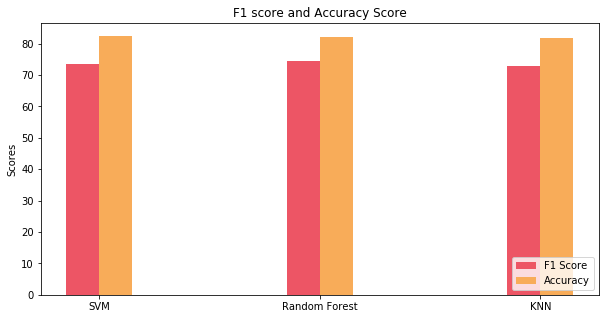

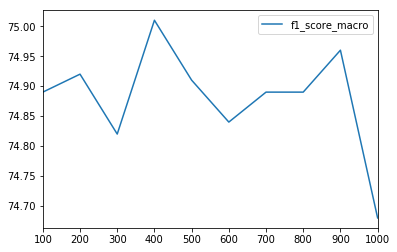

In [48]:
if __name__ == "__main__":
    main()

#### References
#https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame
#https://stackoverflow.com/questions/39214164/data-conversion-error-while-applying-a-function-to-each-row-in-pandas-python
#https://stackoverflow.com/questions/38413579/what-is-the-difference-between-sklearn-labelencoder-and-pd-get-dummies
#https://www.reddit.com/r/MachineLearning/comments/3nuh7g/is_it_effective_to_use_one_hot_encoding_of/
#https://medium.com/analytics-vidhya/accuracy-vs-f1-score-6258237beca2
#https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.line.html
